In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import msgpack

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_deltas(deltas, **kwargs):
    kernel = 1000
    plt.plot(np.cumsum(deltas)[kernel//2-1:-(kernel//2)]/1000., 1000./moving_average(deltas, kernel), **kwargs)

In [ ]:
mountain_6min = np.load("python/traces/debug.npy")

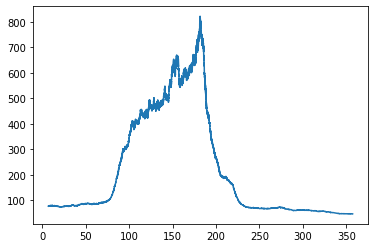

In [23]:
plot_deltas(mountain_6min)

In [24]:
with open("k8s/DRL_lineage", 'rb') as f:
    unpacker = msgpack.Unpacker(f)
    lineage = list(unpacker)

In [25]:
from itertools import chain
flattened_lineage = list(chain.from_iterable(lineage))
lineage_df = pd.DataFrame(flattened_lineage)

In [26]:
observed_deltas = np.diff(sorted(lineage_df[b"_1_lg_sent"]))*1000
e2e_lats = np.array(lineage_df[b"_4_done_time"] - lineage_df[b"_1_lg_sent"])*1000
sorted_indices = np.argsort(lineage_df[b"_1_lg_sent"])
e2e_lats_ts = lineage_df[b"_1_lg_sent"][sorted_indices]
e2e_lats = e2e_lats[sorted_indices]
e2e_lats_ts-=e2e_lats_ts[0]

In [27]:
processing_times = np.array(lineage_df[b"_4_done_time"] - lineage_df[b"_3_dequeue_time"]) * 1000. 

In [28]:
queue_times = np.array(lineage_df[b"_3_dequeue_time"] - lineage_df[b"_2_enqueue_time"]) * 1000. 
queue_times = queue_times[sorted_indices]

In [29]:
with open("k8s/DRL_metrics", 'rb') as f:
    unpacker = msgpack.Unpacker(f)
    metrics = list(unpacker)

In [30]:
metrics_ts = np.array([m[b"current_time_ns"] for m in metrics])
metrics_ts-=metrics_ts[0]
metrics_ts = metrics_ts/1e9

In [31]:
active_rf = [m[b'num_active_replica'] for m in metrics]
active_queue_size = [np.sum(m[b"queue_sizes"]) for m in metrics]

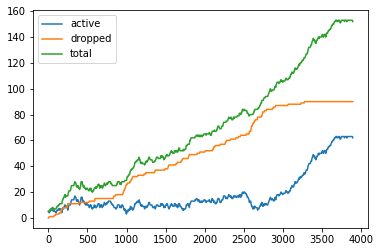

In [32]:
plt.plot(metrics_ts, [m[b'num_active_replica'] for m in metrics], label="active")
plt.plot(metrics_ts, [m[b'num_dropped_replica'] for m in metrics], label="dropped")
plt.plot(metrics_ts, [m[b'num_total_replica'] for m in metrics], label="total")
plt.legend()

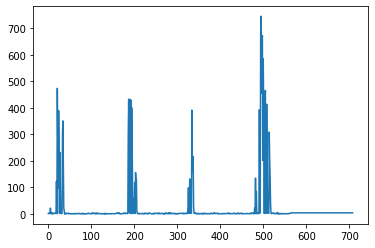

In [33]:
plt.plot([np.max(m[b"queue_sizes"]) - np.min(m[b"queue_sizes"]) for m in metrics])

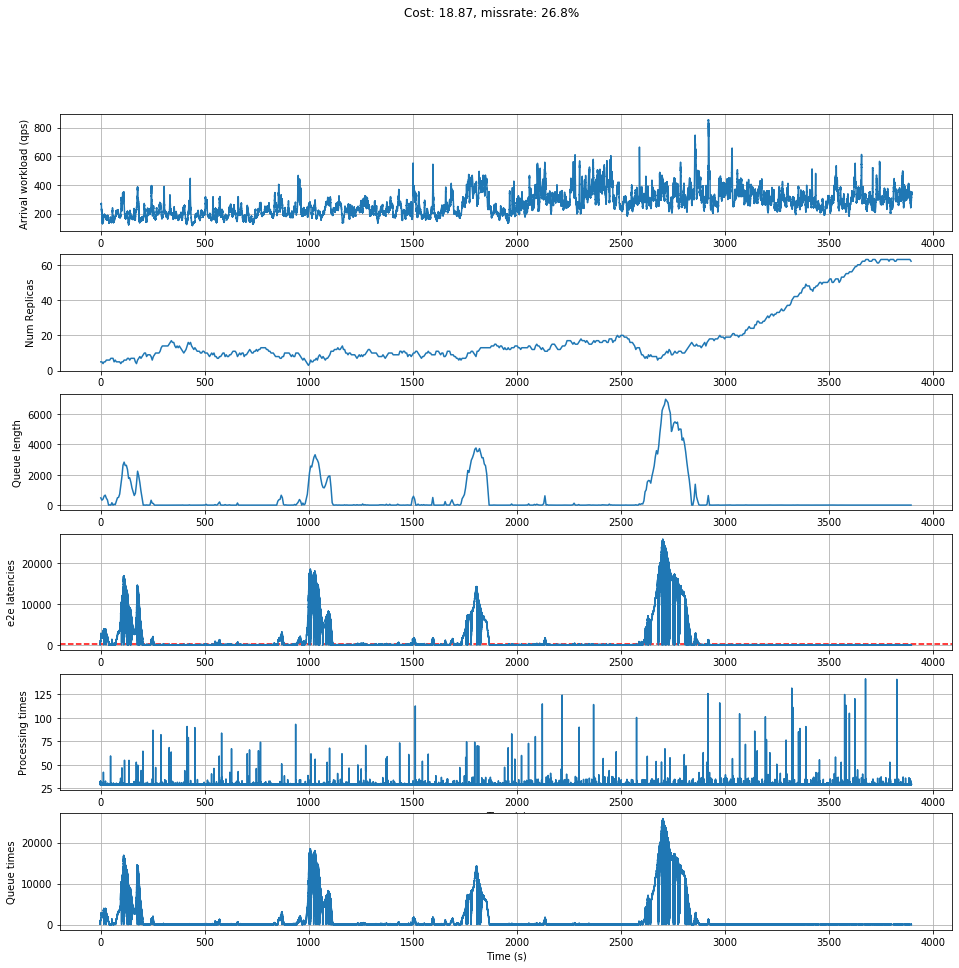

In [35]:
fig=plt.figure(figsize=(16,15))
slo = 150
missrate = np.sum(e2e_lats > slo) / len(observed_deltas)
cost = np.mean(active_rf)
plt.suptitle("Cost: {}, missrate: {}%".format(round(cost, 2), round(missrate*100, 2)))
ax1 = plt.subplot(6,1,1)
plt.ylabel("Arrival workload (qps)")
plt.grid()
plot_deltas(observed_deltas)
ax2 = plt.subplot(6,1,2, sharex = ax1)
plt.ylabel("Num Replicas")
plt.grid()
plt.plot(metrics_ts, active_rf) #, marker="o")
ax2 = plt.subplot(6,1,3, sharex = ax1)
plt.ylabel("Queue length")
plt.grid()
plt.plot(metrics_ts, active_queue_size)
ax2 = plt.subplot(6,1,4, sharex = ax1)
plt.ylabel("e2e latencies")
plt.grid()
plt.axhline(y=slo, color="red", linestyle="--")
plt.plot(e2e_lats_ts, e2e_lats)
ax2 = plt.subplot(6,1,5, sharex = ax1)
plt.plot(e2e_lats_ts, processing_times)
plt.ylabel("Processing times")
plt.xlabel("Time (s)")
plt.grid()
ax2 = plt.subplot(6,1,6, sharex = ax1)
plt.plot(e2e_lats_ts, queue_times)
plt.ylabel("Queue times")
plt.xlabel("Time (s)")
plt.grid()